In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2
import scipy.stats

<h1>Estrutura do projeto</h1>
<p>
1. Definição do problema<br>
2. Coleta de dados<br>
4. Análise exploratória dos dados<br>
5. Feature Engineering<br>
6. Modelos preditivos<br>
7. Resultados<br>
</p>    

<h1>1. Definição do problema</h1>
O desafio encontra-se na plataforma <a href="https://www.kaggle.com/competitions/titanic/overview/description">Kaggle</a>.<br>
'O naufrágio do Titanic é um dos naufrágios mais infames da história.
Em 15 de abril de 1912, durante sua viagem inaugural, o amplamente considerado “inafundável” RMS Titanic afundou após colidir com um iceberg. Infelizmente, não havia botes salva-vidas suficientes para todos a bordo, resultando na morte de 1.502 dos 2.224 passageiros e tripulantes.
Embora houvesse algum elemento de sorte envolvido na sobrevivência, parece que alguns grupos de pessoas eram mais propensos a sobreviver do que outros.
Neste desafio, pedimos que você construa um modelo preditivo que responda à pergunta: “que tipo de pessoa tem mais probabilidade de sobreviver?” usando dados de passageiros (ou seja, nome, idade, sexo, classe socioeconômica, etc).'

<h1>2. Coleta de dados</h1>

In [3]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')
train_data=train_data.drop(['PassengerId'],axis=1)
test_data=test_data.drop(['PassengerId'],axis=1)

<h3>Significado das colunas</h3>

* Survived: Sobrevivência, *0= Não, 1 = Sim*
* Pclass: Classe do ticket, *1 = 1°, 2 = 2°, 3 = 3°*
* Sex: Sexo
* Age: Idade em anos
* SibSp: Número de irmãos / cônjuges presentes no Titanic
* Parch: Números de pais / filhos presentes no Titanic
* Ticket: Número do ticket
* Fare: Tarifa do passageiro
* Cabin: Números da cabine
* Embarked: Porto de embarcação, *C = Cherbourg, Q = Queenstown, S = Southampton*

<h1>3. Análise exploratória dos dados</h1>

In [4]:
pp.ProfileReport(train_data, title= 'Relatório dados de treino')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
pp.ProfileReport(test_data, title="Relatório dados de teste")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<h3>Conclusões com os relatórios</h3>
1. A classe do ticket possui uma forte relação com a tarifa do passeiro, pois quanto maior o valor pago, melhor será a classe adquirida.<br>
2. Há muitos nomes distintos na categoria Name, o que não permite fazer uma análise do impacto dessa categoria na sobrevivência. Porém há muitos títulos e pronomes de tratamentos em comum. Deste modo, pode ser criada uma nova feature para analisar o impacto dos títulos.<br>
3. O sexo possui forte correlação com a sobrevivência, possivelmente relacionado à cultura de prioridade de salvação de mulheres e crianças.<br>
4. As categorias Parch e SibSp possui forte correlação e apresentam uma grande quantidade de zeros. No processo de feature engineering pode-se unir essas categorias para uma melhor representação.<br>
5. Os dados sobre as cabines possuem mais de 77% valores em branco, logo está coluna será desconsiderada para a análise.<br>
6. Os valores das idade em branco podem ser completadas, pois são poucos valores faltantes.<br>

<h2>Análises univariada e multivariada</h2>
<h3>Age</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

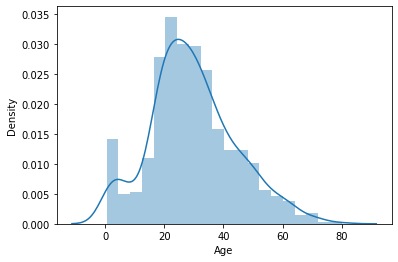

In [6]:
sns.distplot(train_data['Age'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Age'>

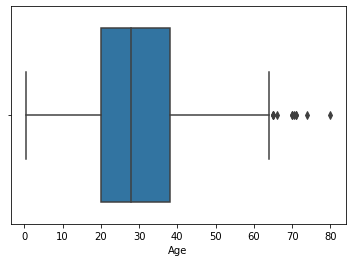

In [7]:
sns.boxplot(train_data['Age'])

Apesar de existirem valores outliers, a análise irá incluir esses valores, pois são idades aceitáveis.

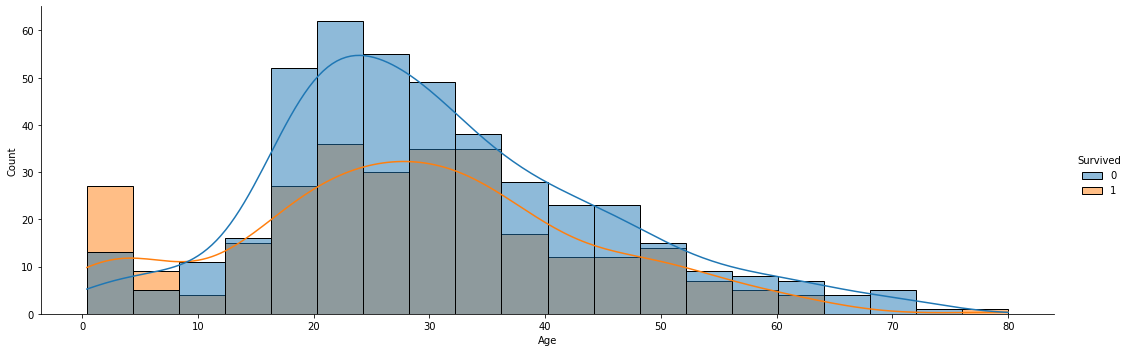

In [8]:
sns.displot(data=train_data,x='Age',hue='Survived',kde=True,aspect=3)

Através deste gráfico é possível perceber que as crianças com idade menor que aproximadamente 10 anos obtiveram uma taxa maior de sobrevivência em relação ao restante das idades.

<h3>Fare</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

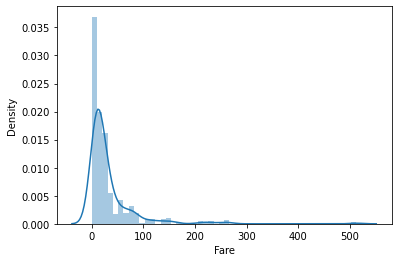

In [9]:
sns.distplot(train_data['Fare'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Fare'>

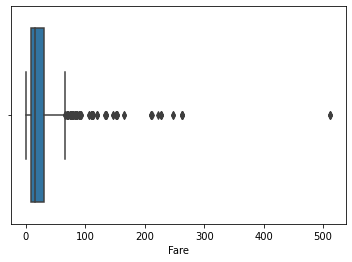

In [10]:
sns.boxplot(train_data['Fare'])

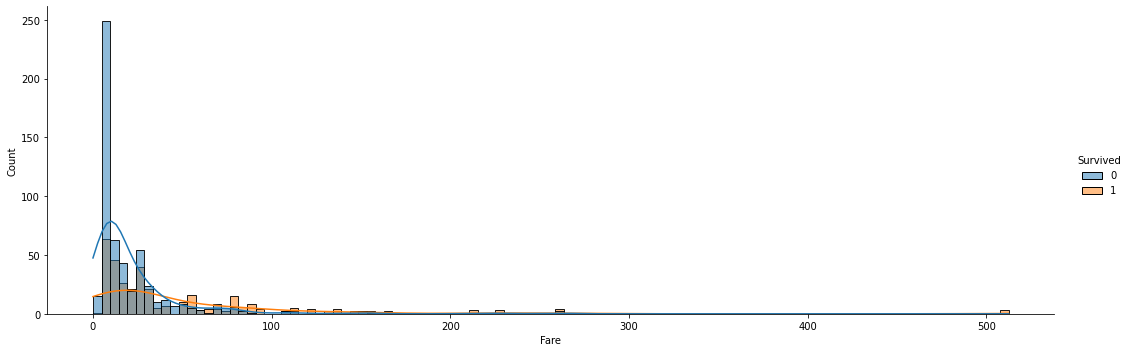

In [11]:
sns.displot(data=train_data,x='Fare',hue='Survived',kde=True,aspect=3)

(0.0, 50.0)

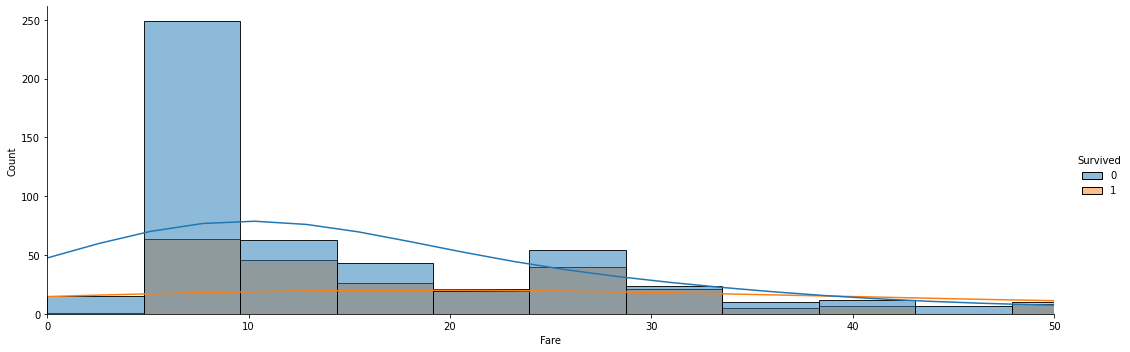

In [12]:
sns.displot(data=train_data,x='Fare',hue='Survived',kde=True,aspect=3)
plt.xlim(0, 50)

Os valores relacionados a 'Fare' possuem muitos outliers. Para eliminar esse problema, está coluna será alterada para representar as tarifas em forma de intervalos. Além disso, entre os valores de 5 e 10 houve uma elevada taxa de morte.

<h3>SibSp</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SibSp', ylabel='count'>

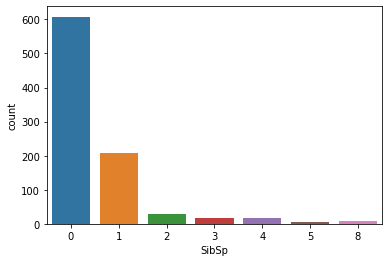

In [13]:
sns.countplot(train_data['SibSp'])

<AxesSubplot:xlabel='SibSp', ylabel='count'>

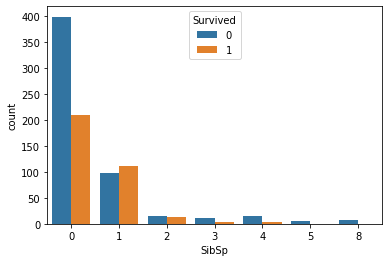

In [14]:
sns.countplot(data=train_data,x='SibSp',hue='Survived')

<h3>Parch</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Parch', ylabel='count'>

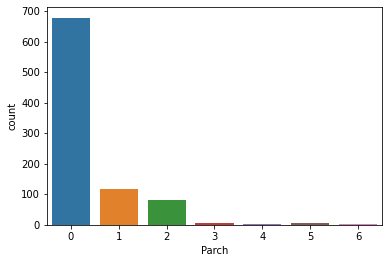

In [15]:
sns.countplot(train_data['Parch'])

<AxesSubplot:xlabel='Parch', ylabel='count'>

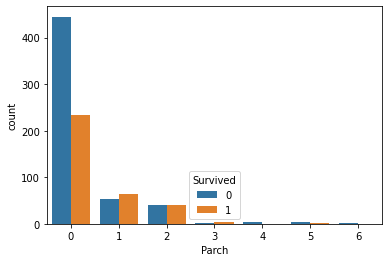

In [16]:
sns.countplot(data=train_data,x='Parch',hue='Survived')

Nas categorias Parch e SibSp, o número de pessoas com 0 familiares que sobreviveram foi consideravelmente menor que o número de pessoas que faleceram. 

<h3>Survived</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Survived', ylabel='count'>

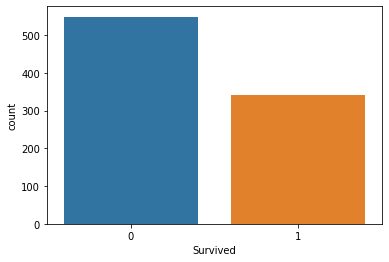

In [17]:
sns.countplot(train_data['Survived'])

<h3>Sex</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sex', ylabel='count'>

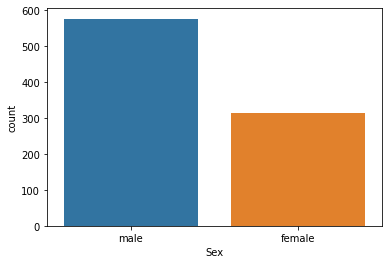

In [18]:
sns.countplot(train_data['Sex'])

<AxesSubplot:xlabel='Sex', ylabel='count'>

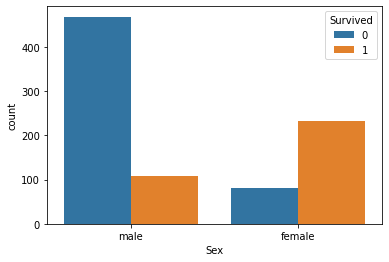

In [19]:
sns.countplot(x="Sex", hue="Survived", data=train_data)

É possível observar que as mulheres obtiveram um alto índice de sobrevivência em relação ao sexo masculino.

<h3>Pclass</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Pclass', ylabel='count'>

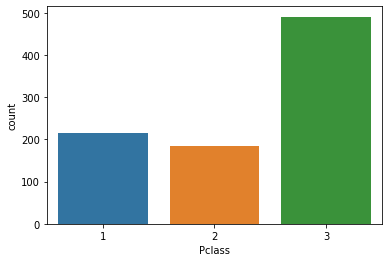

In [20]:
sns.countplot(train_data['Pclass'])

<AxesSubplot:xlabel='Pclass', ylabel='count'>

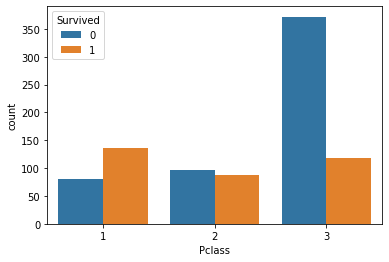

In [21]:
sns.countplot(data=train_data,hue='Survived',x='Pclass')

Na categoria 3 houve um elevado número de mortes em comparação as outras categorias.

<h3>Embarked</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Embarked', ylabel='count'>

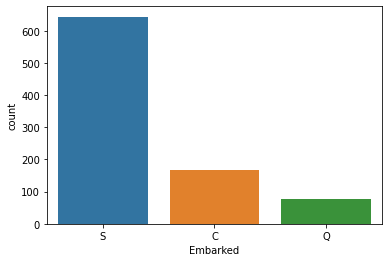

In [22]:
sns.countplot(train_data['Embarked'])

<AxesSubplot:xlabel='Embarked', ylabel='count'>

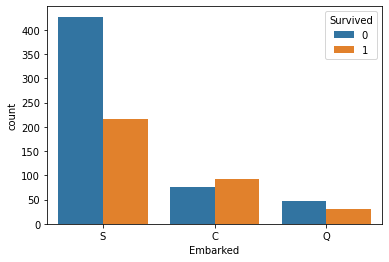

In [23]:
sns.countplot(data=train_data,hue='Survived',x='Embarked')

No embarque S houve aproximadamente o dobro de mortes do que os sobreviventes do mesmo embarque.

<h3>Matriz de correlação</h3>

<AxesSubplot:>

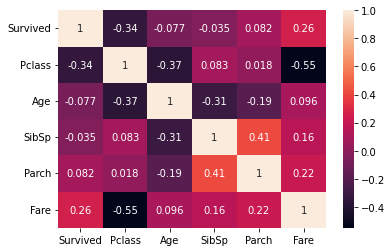

In [24]:
sns.heatmap(train_data.corr(),annot=True)

<h3>Gráficos multivariáveis</h3>

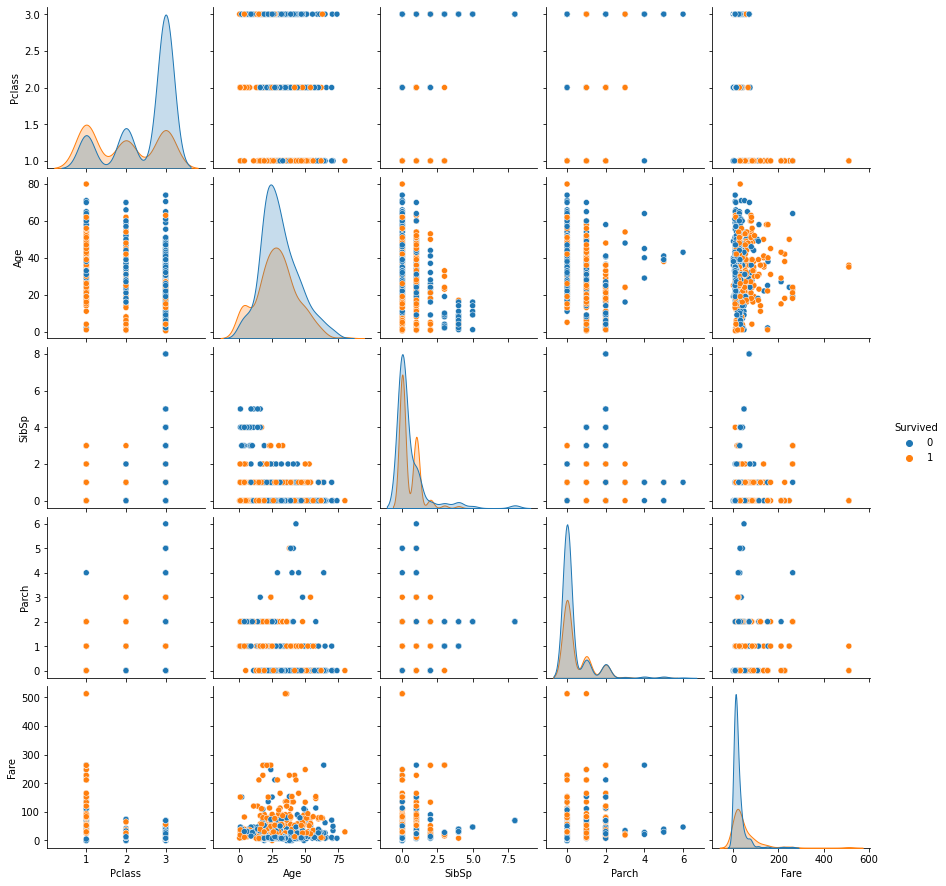

In [25]:
sns.pairplot(train_data,hue='Survived')

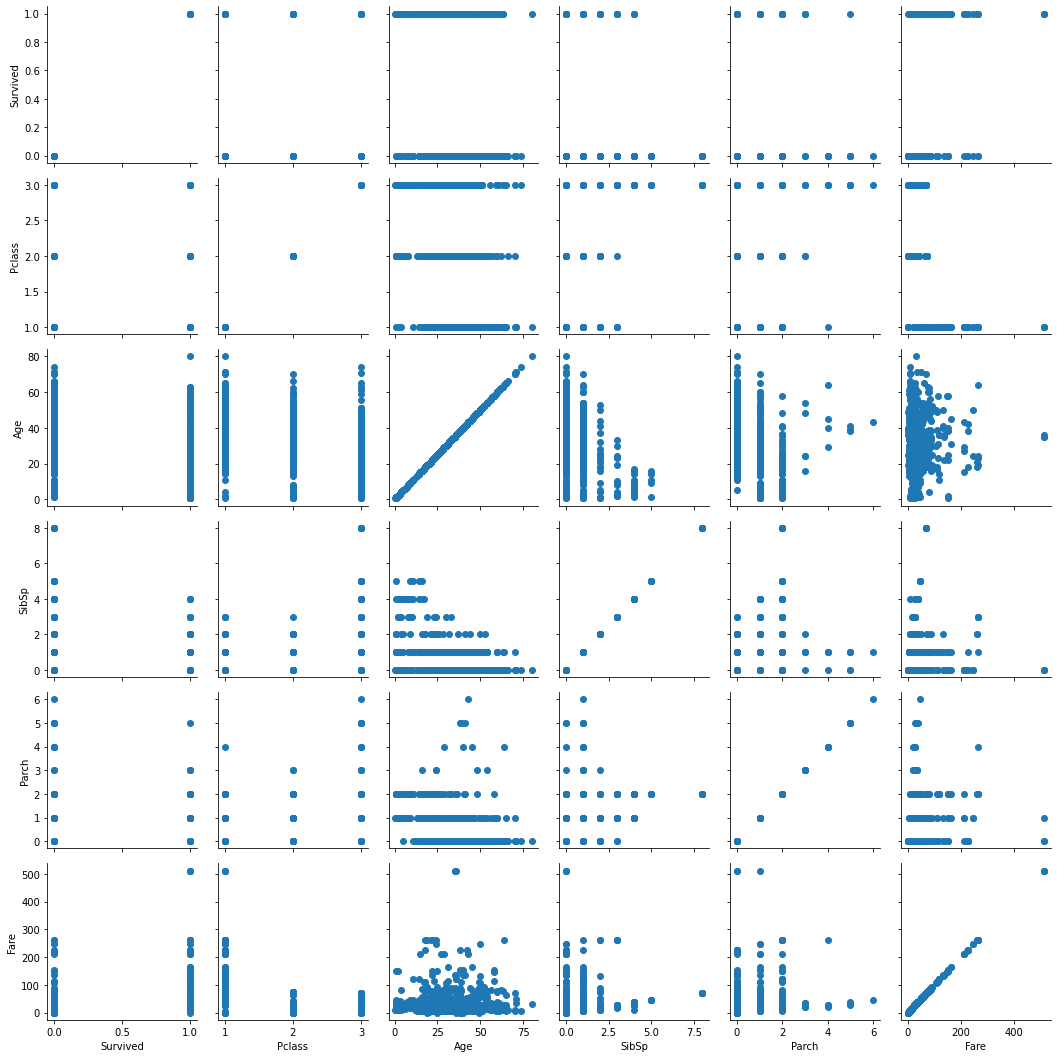

In [26]:
pair_grid_plot = sns.PairGrid(data=train_data)
pair_grid_plot.map(plt.scatter)
plt.show()

<h1>4. Feature Engineering</h1>

<h3>Remoção de colunas e linhas desnecessárias</h3>


In [27]:
#retirar a coluna de cabines e tickets
train_data=train_data.drop(['Cabin','Ticket'],axis=1)
test_data=test_data.drop(['Cabin','Ticket'],axis=1)

#retirar as 2 linhas que possuem 'Embarked' em branco dos dados de treino
train_data=train_data.dropna(subset=['Embarked'])

train_data.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch     Fare Embarked  
0    male  22.0      1      0   7.2500        S  
1  female  38.0      1      0  71.2833        C  
2  female  26.0      0      0   7.9250        S  
3  female  35.0      1      0  53.1000        S  
4    male  35.0      0      0   8.0500        S

<h3>Criação de novas features</h3>


In [28]:
#criação da feature "Alone" - 0: Aconpanhado; 1: Sozinho
train_data['Alone']=train_data['SibSp']+train_data['Parch']
train_data.loc[(train_data['SibSp']+train_data['Parch'])==0,'Alone']=1
train_data.loc[(train_data['SibSp']+train_data['Parch'])>0,'Alone']=0
test_data['Alone']=test_data['SibSp']+test_data['Parch']
test_data.loc[(test_data['SibSp']+test_data['Parch'])==0,'Alone']=1
test_data.loc[(test_data['SibSp']+test_data['Parch'])>0,'Alone']=0

train_data['Fare']=train_data['Fare']/(train_data['SibSp']+train_data['Parch']+1)
test_data['Fare']=test_data['Fare']/(test_data['SibSp']+test_data['Parch']+1)

<AxesSubplot:xlabel='Alone', ylabel='count'>

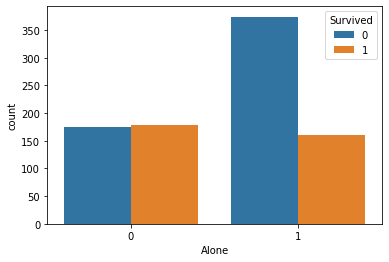

In [29]:
sns.countplot(data=train_data,x='Alone',hue='Survived')

É possível concluir que entre os que estava sozinhos houve uma grande quantidade de mortes.

In [30]:
#criação da feature "Title"
train_data['Title']=train_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
train_data['Title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Analisando somente os títulos que estão presentes na categoria de nomes, vemos que os mais evidentes são de 'Mr', 'Miss', 'Mrs e 'Master. Os outros títulos que apresentam menores frequências serão agrupados em uma nova classificação.

In [31]:
test_data['Title']=test_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [32]:
train_data.loc[(train_data['Title'] != 'Mr') & (train_data['Title'] !='Miss') & (train_data['Title'] !='Mrs') & (train_data['Title'] !='Master'),'Title']='Others'
test_data.loc[(test_data['Title'] != 'Mr') & (test_data['Title'] !='Miss') & (test_data['Title'] !='Mrs') & (test_data['Title'] !='Master'),'Title']='Others'

<AxesSubplot:xlabel='Title', ylabel='count'>

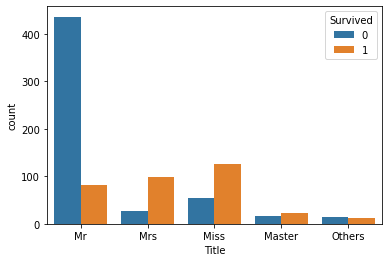

In [33]:
sns.countplot(data=train_data,x='Title',hue='Survived')

<h3>Preencher valores faltantes</h3>


In [34]:
#preencher valores faltantes da idade, será utilizado a média de idades referentes ao título.
train_data['Age'].fillna(train_data.groupby('Title')['Age'].transform('mean'),inplace=True)
test_data['Age'].fillna(test_data.groupby('Title')['Age'].transform('mean'),inplace=True)

<h3>Transformação de features</h3>


In [35]:
#transformar a coluna de idade em categorias
train_data['Age_Cat']= 0
train_data.loc[train_data['Age']<=10,'Age_Cat']=0
train_data.loc[(train_data['Age']>10) & (train_data['Age']<=20),'Age_Cat']=1
train_data.loc[(train_data['Age']>20) & (train_data['Age']<=50),'Age_Cat']=2
train_data.loc[train_data['Age']>50,'Age_Cat']=3

test_data['Age_Cat']= 0
test_data.loc[test_data['Age']<=10,'Age_Cat']=0
test_data.loc[(test_data['Age']>10) & (test_data['Age']<=20),'Age_Cat']=1
test_data.loc[(test_data['Age']>20) & (test_data['Age']<=50),'Age_Cat']=2
test_data.loc[test_data['Age']>50,'Age_Cat']=3


<AxesSubplot:xlabel='Age_Cat', ylabel='count'>

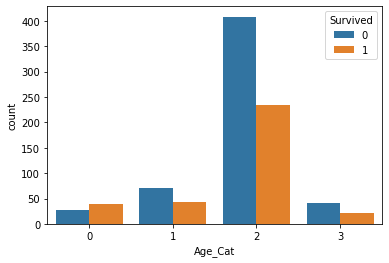

In [36]:
sns.countplot(data=train_data,x='Age_Cat',hue='Survived')

In [37]:
#transformar a coluna de tarifa em categorias
train_data['Fare_Cat']= 0
train_data.loc[train_data['Fare']<=10,'Fare_Cat']=0
train_data.loc[(train_data['Fare']>10) & (train_data['Fare']<=20),'Fare_Cat']=1
train_data.loc[(train_data['Fare']>20) & (train_data['Fare']<=50),'Fare_Cat']=2
train_data.loc[(train_data['Fare']>50) & (train_data['Fare']<=100),'Fare_Cat']=3
train_data.loc[train_data['Fare']>100,'Fare_Cat']=4

test_data['Fare_Cat']= 0
test_data.loc[test_data['Fare']<=10,'Fare_Cat']=0
test_data.loc[(test_data['Fare']>10) & (test_data['Fare']<=20),'Fare_Cat']=1
test_data.loc[(test_data['Fare']>20) & (test_data['Fare']<=50),'Fare_Cat']=2
test_data.loc[(test_data['Fare']>50) & (test_data['Fare']<=100),'Fare_Cat']=3
test_data.loc[test_data['Fare']>100,'Fare_Cat']=4

<AxesSubplot:xlabel='Fare_Cat', ylabel='count'>

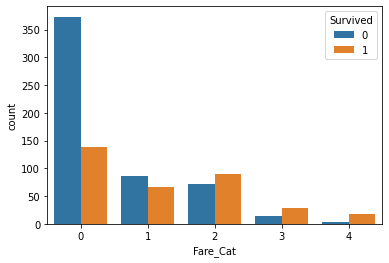

In [38]:
sns.countplot(data=train_data,x='Fare_Cat',hue='Survived')

In [39]:
train_data.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch      Fare Embarked  Alone Title  Age_Cat  \
0    male  22.0      1      0   3.62500        S      0    Mr        2   
1  female  38.0      1      0  35.64165        C      0   Mrs        2   
2  female  26.0      0      0   7.92500        S      1  Miss        2   
3  female  35.0      1      0  26.55000        S      0   Mrs        2   
4    male  35.0      0      0   8.05000        S      1    Mr        2   

   Fare_Cat  
0         0  
1         2  
2         0  
3         2  
4         0

In [40]:
#deletando as colunas que não serão usadas na análise
train_data=train_data.drop(['Name','SibSp','Parch','Fare','Age'],axis=1)
train_data=train_data.reset_index(drop=True)
test_data=test_data.drop(['Name','SibSp','Parch','Fare','Age'],axis=1)

In [41]:
pp.ProfileReport(train_data,title="Relatório dados treino")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
pp.ProfileReport(test_data,title="Relatório dados teste")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<h3>Teste qui quadrado</h3>
Para verificar se as caracteristicas selecionadas possuem relação com a categoria de sobrevivência,deste modo será criado modelos de previssão mais robustos, será utilizado o teste de qui quadrado. Se o qui calculado é maior ou igual que o qui crítico, a hipótese nula é rejeitada e as variáveis são dependentes, caso contrário não haverá relação entre as variáveis. Foi escolhido um nível de significância de 5% e haverá as seguintes hipóteses:<br>
* H0 : Não existe relação entre as duas variáveis.<br>
* H1 : Existe relação entre as duas variáveis.

In [43]:
from scipy.stats import chi2
def chi_test(df,col1,col2):
    
    contingency_table=pd.crosstab(df[col1],df[col2])

    #valores observados
    Observed_Values = contingency_table.values 

    #valores esperados
    b=scipy.stats.chi2_contingency(contingency_table)
    Expected_Values = b[3]

    #grau de liberdade
    no_of_rows=len(contingency_table.iloc[0:2,0])
    no_of_columns=len(contingency_table.iloc[0,0:2])
    df=(no_of_rows-1)*(no_of_columns-1)

    alpha=0.05

    chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
    chi_square_statistic=chi_square[0]+chi_square[1]

    critical_value=chi2.ppf(q=1-alpha,df=df)

    if chi_square_statistic>=critical_value:
        print("Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.")
    else:
        print("Qui calculado é menor que o Qui crítico, logo a hipótese nula não pode ser rejeitada.")

In [44]:
chi_test(train_data,'Sex','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


In [45]:
chi_test(train_data,'Pclass','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


In [46]:
chi_test(train_data,'Embarked','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


In [47]:
chi_test(train_data,'Alone','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


In [48]:
chi_test(train_data,'Title','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


In [49]:
chi_test(train_data,'Age_Cat','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


In [50]:
chi_test(train_data,'Fare_Cat','Survived')

Qui calculado é maior ou igual que o Qui crítico, logo a hipótese nula é rejeitada com um nível de significância de 5% e as variáveis são dependentes.


<h3>Codificação dos dados</h3>


In [51]:
train_data_r=train_data.copy()
test_data_r=test_data.copy()
for columns in test_data.columns:
    train_data_r[columns] = train_data[columns].apply(str)
    test_data_r[columns] = test_data[columns].apply(str)
train_data_r=train_data_r.drop(['Survived'],axis=1)
train_data_r = pd.get_dummies(train_data_r,drop_first=True)
test_data_r = pd.get_dummies(test_data_r,drop_first=True)
survived_data_r=train_data['Survived']
train_data_r.head()

Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  Alone_1  Title_Miss  \
0         0         1         1           0           1        0           0   
1         0         0         0           0           0        0           0   
2         0         1         0           0           1        1           1   
3         0         0         0           0           1        0           0   
4         0         1         1           0           1        1           0   

   Title_Mr  Title_Mrs  Title_Others  Age_Cat_1  Age_Cat_2  Age_Cat_3  \
0         1          0             0          0          1          0   
1         0          1             0          0          1          0   
2         0          0             0          0          1          0   
3         0          1             0          0          1          0   
4         1          0             0          0          1          0   

   Fare_Cat_1  Fare_Cat_2  Fare_Cat_3  Fare_Cat_4  
0           0           0           0           0  
1           0           1           0           0  
2           0           0           0           0  
3           0           1           0           0  
4           0           0           0           0

In [52]:
test_data_r.head()

Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  Alone_1  Title_Miss  \
0         0         1         1           1           0        1           0   
1         0         1         0           0           1        0           0   
2         1         0         1           1           0        1           0   
3         0         1         1           0           1        1           0   
4         0         1         0           0           1        0           0   

   Title_Mr  Title_Mrs  Title_Others  Age_Cat_1  Age_Cat_2  Age_Cat_3  \
0         1          0             0          0          1          0   
1         0          1             0          0          1          0   
2         1          0             0          0          0          1   
3         1          0             0          0          1          0   
4         0          1             0          0          1          0   

   Fare_Cat_1  Fare_Cat_2  Fare_Cat_3  Fare_Cat_4  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0           0           0           0

In [53]:
survived_data_r.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

<h3>Separação de dados teste e treino</h3>


In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data_r, survived_data_r, test_size = 0.2, random_state= 2) #20% data test

<h1>5. Modelos preditivos</h1>
Serão analisados os seguintes modelos:<br>
* Random Forest<br>
* Gaussian Naive Bayes<br>
* K- Neighbors<br>
* XGB Classifier<br>
* Voting Classifier (Hard)<br>
* Voting Classifier (Soft)<br>
* Redes neurais artificiais<br>
Os modelos de votação serão criados com os 4 modelos de classificação (Random Forest, Gaussian Naive Bayes, K- Neighbors e XGB Classifier), utilizando os modos 'hard' e 'soft'.
Para a regulagem dos hiperparâmetros, o método utilizado foi a a busca randomizada com validação cruzada.

<h3>Random Forest</h3>


In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn.ensemble import RandomForestClassifier
max_depth=randint(5,20)
n_estimators=randint(2,1000)
param_grid = dict(max_depth=max_depth,n_estimators=n_estimators)

random_forest_CV = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_jobs=1,verbose=2)
random_forest_CV.fit(x_train, y_train)
random_forest=random_forest_CV.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................max_depth=18, n_estimators=408; total time=   0.5s
[CV] END .....................max_depth=18, n_estimators=408; total time=   0.5s
[CV] END .....................max_depth=18, n_estimators=408; total time=   0.5s
[CV] END .....................max_depth=18, n_estimators=408; total time=   0.5s
[CV] END .....................max_depth=18, n_estimators=408; total time=   0.5s
[CV] END ......................max_depth=7, n_estimators=194; total time=   0.3s
[CV] END ......................max_depth=7, n_estimators=194; total time=   0.4s
[CV] END ......................max_depth=7, n_estimators=194; total time=   0.4s
[CV] END ......................max_depth=7, n_estimators=194; total time=   0.4s
[CV] END ......................max_depth=7, n_estimators=194; total time=   0.4s
[CV] END ......................max_depth=17, n_estimators=93; total time=   0.2s
[CV] END ......................max_depth=17, n_e

In [56]:
from sklearn.metrics import accuracy_score
y_pred=random_forest.predict(x_test)
score_random_forest=accuracy_score(np.array(y_test), (y_pred))
print(score_random_forest)

0.8089887640449438


<h3>Gaussian Naive Bayes</h3>


In [57]:
from sklearn.naive_bayes import GaussianNB
var_smoothing=np.logspace(0,-9, num=100)
param_grid = dict(var_smoothing=var_smoothing)

gaussian_nb_CV = RandomizedSearchCV(estimator=GaussianNB(), param_distributions=param_grid, n_jobs=1,verbose=1,n_iter=200)
gaussian_nb_CV.fit(x_train, y_train)
gaussian_nb=gaussian_nb_CV.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 100 is smaller than n_iter=200. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [58]:
y_pred=gaussian_nb.predict(x_test)
score_gaussian_nb=accuracy_score(np.array(y_test), (y_pred))
print(score_gaussian_nb)

0.8033707865168539


<h3>K- Neighbors</h3>


In [59]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors=randint(3,10)
weights=['uniform', 'distance']
algorithm=['auto', 'ball_tree','kd_tree','brute']
p=[1,2]
param_grid = dict(n_neighbors=n_neighbors,weights=weights,algorithm=algorithm,p=p)

k_neighbors_CV = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=param_grid, n_jobs=1,verbose=1,n_iter=500)
k_neighbors_CV.fit(x_train, y_train)
k_neighbors=k_neighbors_CV.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [60]:
y_pred=k_neighbors.predict(x_test)
score_k_neighbors=accuracy_score(np.array(y_test), (y_pred))
print(score_k_neighbors)

0.8314606741573034


<h3>XGB Classifier</h3>

In [61]:
from xgboost import XGBClassifier
max_depth=randint(3,20)
n_estimators=randint(3,1000)
learning_rate=[0.01, 0.1, 0.2, 0.3]
colsample_bytree=np.arange(0.4, 1.0, 0.1)
colsample_bylevel=np.arange(0.4, 1.0, 0.1)
param_grid = dict(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                  colsample_bytree=colsample_bytree,colsample_bylevel=colsample_bylevel)

xgb_classifier_CV = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_grid, n_jobs=1,verbose=2)
xgb_classifier_CV.fit(x_train, y_train)
xgb_classifier=xgb_classifier_CV.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=898; total time=   2.2s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=898; total time=   2.1s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=898; total time=   2.1s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=898; total time=   2.1s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=898; total time=   2.1s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.7999999999999999, learning_rate=0.2, max_depth=8, n_estimators=581; total time=   1.4s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.7999999999999999, learning_rat

In [62]:
y_pred=xgb_classifier.predict(x_test)
score_xgb_classifier=accuracy_score(np.array(y_test), (y_pred))
print(score_xgb_classifier)

0.8258426966292135


<h3>Redes neurais artificiais</h3>


In [63]:
import tensorflow as tf   
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def create_model_RN(n,ln,fun,layer2,epochs):

    initializer = tf.compat.v1.keras.initializers.glorot_uniform(seed=0)
    model = Sequential()
    model.add(Dense(int(n), input_dim=x_train.shape[1], activation=fun,
                    use_bias=True,kernel_initializer=initializer))
    if layer2==True:
        model.add(Dense(n, activation=fun,use_bias=True,kernel_initializer=initializer)) # Hidden 2
    model.add(Dense(1,activation='sigmoid',kernel_initializer=initializer)) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=ln)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

#range of hyperparameters
ln = [0.1,0.01,0.001, 0.0001]
n=randint(1,100)
layer2=[False,True]
epochs=randint(10,200)
fun=['tanh','relu']
param_grid = dict(n=n,ln=ln,fun=fun,layer2=layer2,epochs=epochs)

model_RN = KerasRegressor(build_fn=create_model_RN, verbose=0)

rede_neural_CV = RandomizedSearchCV(estimator=model_RN, param_distributions=param_grid, n_jobs=1,verbose=2)
rede_neural_CV.fit(x_train, y_train)
rede_neural=rede_neural_CV.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2022-05-29 22:52:57.607546: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-29 22:52:57.683145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[CV] END ....epochs=115, fun=relu, layer2=True, ln=0.1, n=85; total time=   5.9s
[CV] END ....epochs=115, fun=relu, layer2=True, ln=0.1, n=85; total time=   4.6s
[CV] END ....epochs=115, fun=relu, layer2=True, ln=0.1, n=85; total time=   4.7s
[CV] END ....epochs=115, fun=relu, layer2=True, ln=0.1, n=85; total time=   4.6s
[CV] END ....epochs=115, fun=relu, layer2=True, ln=0.1, n=85; total time=   4.5s
[CV] END ..epochs=151, fun=relu, layer2=True, ln=0.001, n=69; total time=   5.1s
[CV] END ..epochs=151, fun=relu, layer2=True, ln=0.001, n=69; total time=   5.7s
[CV] END ..epochs=151, fun=relu, layer2=True, ln=0.001, n=69; total time=   5.4s
[CV] END ..epochs=151, fun=relu, layer2=True, ln=0.001, n=69; total time=   5.3s
[CV] END ..epochs=151, fun=relu, layer2=True, ln=0.001, n=69; total time=   5.3s
[CV] END .epochs=145, fun=tanh, layer2=False, ln=0.001, n=13; total time=   4.0s
[CV] END .epochs=145, fun=tanh, layer2=False, ln=0.001, n=13; total time=   3.9s
[CV] END .epochs=145, fun=ta

In [64]:
y_pred = rede_neural.predict(x_test)
y_pred=np.where(y_pred > 0.5, 1,0)
score_rede_neural=accuracy_score(np.array(y_test), (y_pred))
print(score_rede_neural)

0.8258426966292135


<h3>Voting Classifier (Hard)</h3>


In [65]:
from sklearn.ensemble import VotingClassifier
votacao_hard=VotingClassifier(estimators=[('random_forest',random_forest),('gaussian_nb',gaussian_nb),('k_neighbors',k_neighbors),
                                          ('xgb_classifier',xgb_classifier)],voting='hard')
votacao_hard.fit(x_train,y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=194)),
                             ('gaussian_nb',
                              GaussianNB(var_smoothing=0.657933224657568)),
                             ('k_neighbors',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=8, p=1)),
                             ('xgb_classifier',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.6,
                                            colsample_byn...
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                      

In [66]:
y_pred=votacao_hard.predict(x_test)
score_votacao_hard=accuracy_score(np.array(y_test), (y_pred))
print(score_votacao_hard)

0.8202247191011236


<h3>Voting Classifier (Soft)</h3>


In [67]:
votacao_soft=VotingClassifier(estimators=[('random_forest',random_forest),('gaussian_nb',gaussian_nb),('k_neighbors',k_neighbors),
                                          ('xgb_classifier',xgb_classifier)],voting='soft')
votacao_soft.fit(x_train,y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=194)),
                             ('gaussian_nb',
                              GaussianNB(var_smoothing=0.657933224657568)),
                             ('k_neighbors',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=8, p=1)),
                             ('xgb_classifier',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.6,
                                            colsample_byn...
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                           

In [68]:
y_pred=votacao_soft.predict(x_test)
score_votacao_soft=accuracy_score(np.array(y_test), (y_pred))
print(score_votacao_soft)

0.8089887640449438


<h1>6. Resultados</h1>

In [69]:
resultado=pd.DataFrame({'Modelo preditivo':['Random Forest','Gaussian NB', 'K-Neighbors', 'XGB', 'Voting (Hard)','Voting (Soft)','Redes Neurais'],
                       'Score': [score_random_forest,score_gaussian_nb,score_k_neighbors,score_xgb_classifier, score_votacao_hard,
                                 score_votacao_soft,score_rede_neural]})
resultado.sort_values('Score',ascending=False)

Modelo preditivo     Score
2      K-Neighbors  0.831461
3              XGB  0.825843
6    Redes Neurais  0.825843
4    Voting (Hard)  0.820225
0    Random Forest  0.808989
5    Voting (Soft)  0.808989
1      Gaussian NB  0.803371

Será submetido o modelo K-Neighbors.

In [71]:
final=k_neighbors.predict(test_data_r)
test_id = pd.read_csv('../input/titanic/test.csv')['PassengerId']
submit = pd.DataFrame({'PassengerId': test_id, 'Survived': final})
submit.to_csv('my_submission.csv', index=False)